In [1]:
import jax
import jax.numpy as jnp
from jax import vmap
import optax
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# use float64
from jax.config import config
config.update("jax_enable_x64", True)

# use retina plots
%config InlineBackend.figure_format='retina'

# generate data

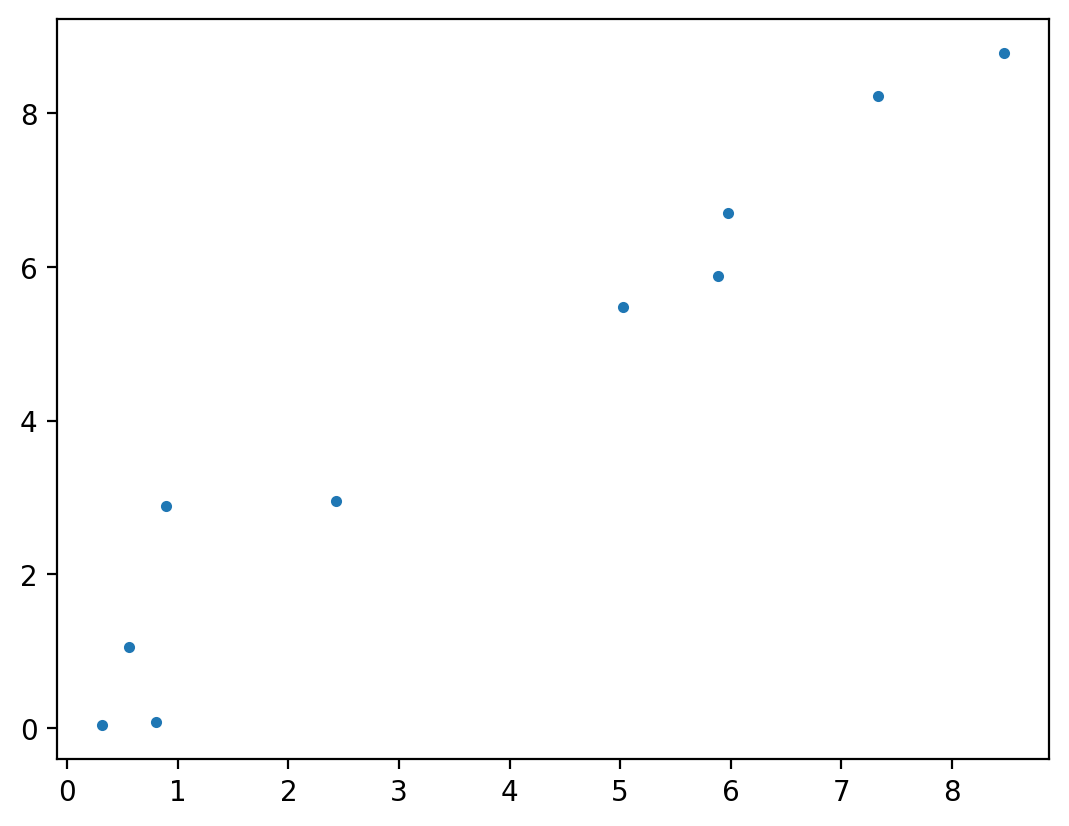

In [3]:
# generate train data
n_train = 10
w_true = 1
noise_sd = 1
ds_key = jax.random.PRNGKey(0)
x_key, y_key = jax.random.split(ds_key, 2)
x_train = 10 * jax.random.uniform(x_key, [n_train, 1])
y_train = w_true * x_train[:, 0] + noise_sd * jax.random.normal(y_key, [n_train])
assert x_train.dtype == jnp.float64
plt.plot(x_train, y_train, '.');

# define kernels

In [4]:
def linear_kernel(x1, x2):
    return jnp.dot(x1, x2)

def gaussian_kernel(x1, x2, sigma):
    return jnp.exp(- ((x1 - x2)**2).sum() / (2*sigma**2))

# analytical solution

In [5]:
def fit_analytical(x_train, y_train, kernel_fn, gamma):
    n_train = len(y_train)
    
    # compute kernel
    K = kernel_fn(x_train, x_train)
    
    # least accurate: matrix inverse
    # alpha = jnp.linalg.inv(K + n_train*gamma) @ y_train
    
    # more accurate: jnp.linalg.solve
    # alpha = jnp.linalg.solve(K + n_train*gamma, y_train)
    
    # even more accurate, works only for positive definite kernels: Cholesky
    # L = jax.scipy.linalg.cho_factor(K + n_train*gamma)
    # alpha = jax.scipy.linalg.cho_solve(L, y_train)
    
    # most accurate: jnp.linalg.lstsq
    alpha = jnp.linalg.lstsq(K + n_train*gamma*jnp.eye(n_train), y_train, rcond=None)[0]
    
    return alpha

# gradient descent

In [6]:
def loss_fn(alpha, x_train, y_train, kernel_fn, gamma):
    
    # compute kernel
    K = kernel_fn(x_train, x_train)

    # compute mse
    y_hat = K @ alpha
    mse = ((y_train - y_hat)**2).mean()

    # compute regularization penalty
    penalty = gamma * alpha.T @ K @ alpha
    
    return mse + penalty

In [7]:
def fit_grad(x_train, y_train, kernel_fn, gamma, learning_rate=1, n_steps=1_000_000):
    
    # initialize optimizer
    alpha = jnp.ones([n_train])
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(alpha)
    
    # do gradient descnet
    def step(i, state):
        alpha, opt_state = state
        grads = jax.grad(loss_fn)(alpha, x_train, y_train, kernel_fn, gamma)
        updates, opt_state = optimizer.update(grads, opt_state)
        alpha = optax.apply_updates(alpha, updates)
        return (alpha, opt_state)
    alpha, _ = jax.lax.fori_loop(0, n_steps, step, (alpha, opt_state))
    
    return alpha

# plot fits

matrix=-0.62, grad=-0.62
matrix= 3.10, grad= 3.10
matrix= 3.30, grad= 3.30
matrix=-0.92, grad=-0.74
matrix=-0.77, grad=-0.74
matrix= 2.91, grad= 2.91


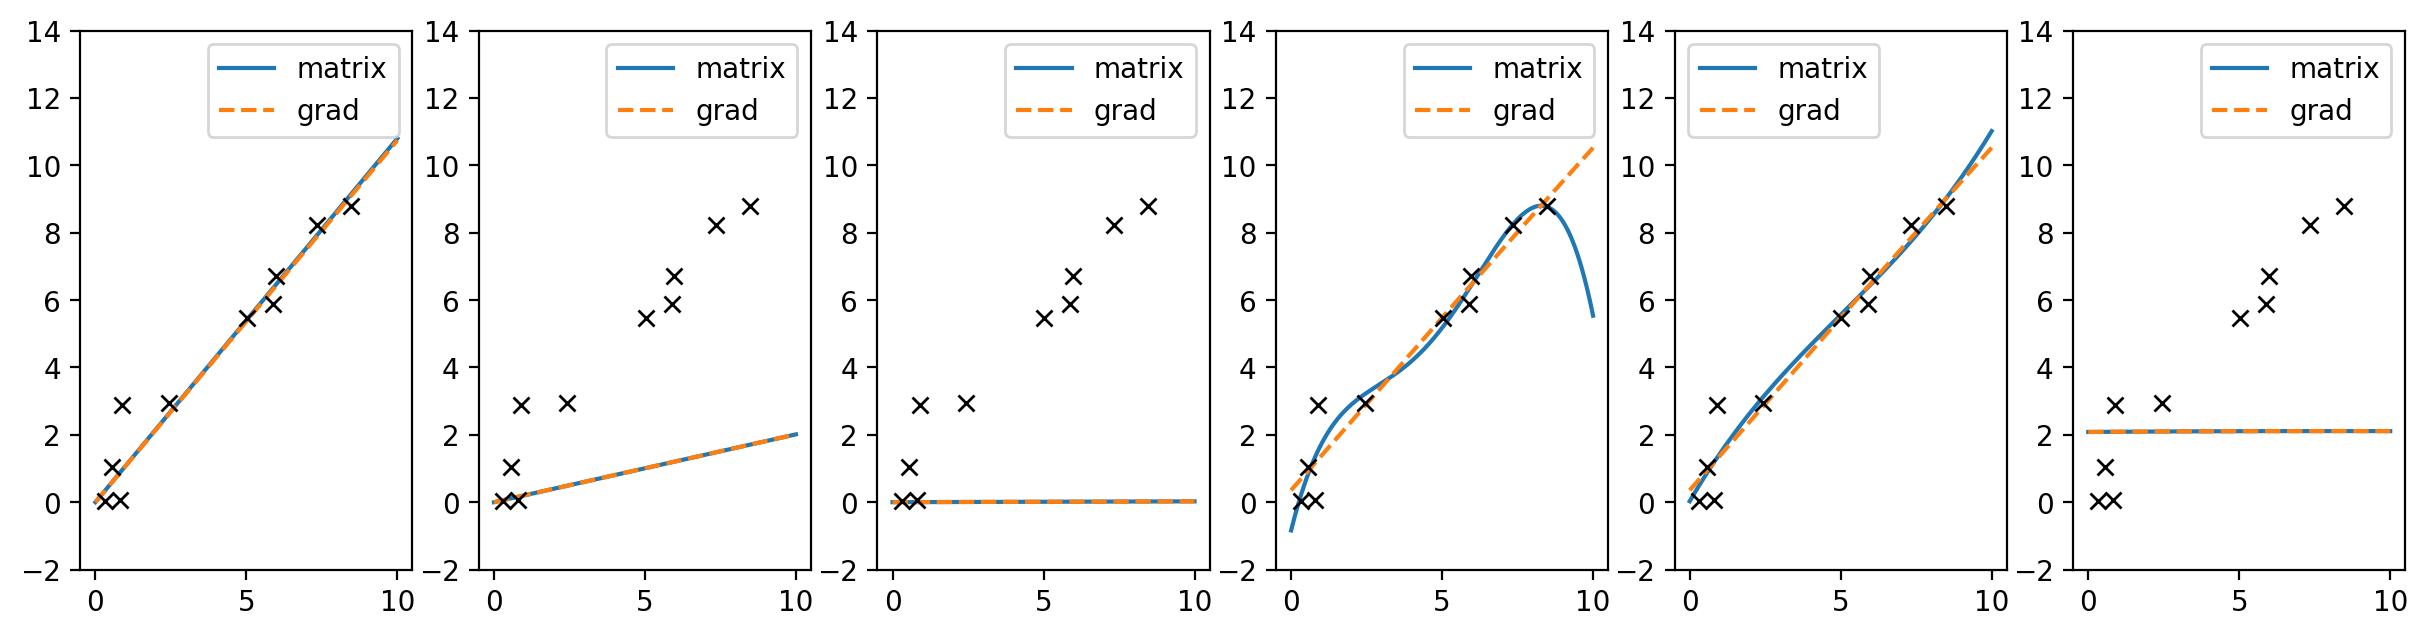

In [8]:
# define hyper-parameters
sigma = 50
hparams = [
    [linear_kernel, 1e-2],
    [linear_kernel, 1e2],
    [linear_kernel, 1e4],
    [lambda x1, x2: gaussian_kernel(x1, x2, sigma), 1e-20],
    [lambda x1, x2: gaussian_kernel(x1, x2, sigma), 1e-10],
    [lambda x1, x2: gaussian_kernel(x1, x2, sigma), 1e0],
]
n_hparam = len(hparams)

# points to evaluate
x_plot = jnp.linspace(0, 10, 1000)

# plot fits
fig, axs = plt.subplots(1, n_hparam, figsize=[15, 3.5])
for i in range(n_hparam):
    ax = axs[i]
    kernel_fn, gamma = hparams[i]
    
    # vectorize kernel function from "([d], [d]) -> []" to "([n1, d], [n2, d]) -> [n1, n2]"
    kernel_fn_vect = vmap(vmap(kernel_fn, in_axes=[None, 0]), in_axes=[0, None])
    
    # matrix solution
    alpha = fit_analytical(x_train, y_train, kernel_fn_vect, gamma)
    y_hat = kernel_fn_vect(x_plot[:, None], x_train) @ alpha
    axs[i].plot(x_plot, y_hat, label='matrix')
    mat_err = loss_fn(alpha, x_train, y_train, kernel_fn_vect, gamma)
    
    # gradient descent solution
    alpha = fit_grad(x_train, y_train, kernel_fn_vect, gamma)
    y_hat = kernel_fn_vect(x_plot[:, None], x_train) @ alpha
    axs[i].plot(x_plot, y_hat, label='grad', ls='--')
    grad_err = loss_fn(alpha, x_train, y_train, kernel_fn_vect, gamma)
    
    # plot data
    ax.plot(x_train, y_train, 'x', c='black')
    
    # misc
    log = jnp.log
    print(f'matrix={float(log(mat_err)): 4.2f}, grad={float(log(grad_err)): 4.2f}')
    ax.set_ylim([-2, 14])
    ax.legend()

plt.show()